In [1]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
DATASET_DIR = r"D:\user\DICOM_images"

In [3]:
category_list = os.listdir(DATASET_DIR)
category_list

['CR-CHEST',
 'CT-ABDOMEN',
 'CT-BREAST',
 'CT-CHEST',
 'CT-COLON',
 'CT-HEADNECK',
 'CT-KIDNEY',
 'CT-LUNG',
 'CT-PANCREAS',
 'DX-CHEST',
 'MG-BREAST',
 'MR-ABDOMEN',
 'MR-BRAIN',
 'MR-BREAST',
 'MR-HEADNECK',
 'MR-KIDNEY',
 'MR-PELVIS',
 'MR-PROSTATE']

In [ ]:
from collections import defaultdict
modality_image = {}
for i in range(len(modality_list)):
    modality_image[modality_list[i]] = defaultdict(list)
    path = r"D:\DICOM_tmp" + "\\" + str(modality_list[i])
    # dir_list = []
    for root, dirs, files in os.walk(path):
        rootpath = os.path.join(os.path.abspath(path), root)
        filepath = []
        for dir in dirs:
            # dir_list.append(dir)
            modality_image[modality_list[i]] = dir
        for file in files:
            filepath.append(os.path.join(rootpath, file))
        if filepath:
            modality_image[modality_list[i]] = filepath

In [4]:
IMG_W = 256
IMG_H = 256
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
EPOCHS = 10
BATCH_SIZE = 32

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(256,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(len(category_list)))
model.add(Activation("softmax"))

In [6]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)       

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

In [9]:
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 43328 images belonging to 18 classes.
Found 14435 images belonging to 18 classes.


In [10]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

MODEL_SAVE_FOLDER_PATH = "./model_saved_changed"
LOG_SAVE_FOLDER_PATH = "./logs_changed"
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(LOG_SAVE_FOLDER_PATH):
    os.mkdir(LOG_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH + "\\" + "{val_accuracy:.2f}-model.h5"

In [11]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.samples // BATCH_SIZE,
    validation_data = val_gen,
    validation_steps = val_gen.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [
        ModelCheckpoint(filepath=model_path, monitor="val_accuracy", verbose=1, save_best_only=True),
        TensorBoard(log_dir=LOG_SAVE_FOLDER_PATH, histogram_freq=0, write_graph=True, write_images=True),
        EarlyStopping(monitor="val_accuracy", min_delta=0.6, patience=4, verbose=0)
    ])

Epoch 1/10
1354/1354 [==============================] - 4304s 3s/step - loss: 0.3655 - accuracy: 0.8882 - val_loss: 0.0158 - val_accuracy: 0.9117

Epoch 00001: val_accuracy improved from -inf to 0.91172, saving model to ./model_saved_changed\0.91-model.h5

Epoch 2/10
1354/1354 [==============================] - 4307s 3s/step - loss: 0.2154 - accuracy: 0.9372 - val_loss: 0.0022 - val_accuracy: 0.9071

Epoch 00002: val_accuracy did not improve from 0.91172
Epoch 3/10
1354/1354 [==============================] - 4310s 3s/step - loss: 0.1859 - accuracy: 0.9464 - val_loss: 0.3397 - val_accuracy: 0.9277

Epoch 00003: val_accuracy improved from 0.91172 to 0.92765, saving model to ./model_saved_changed\0.93-model.h5
Epoch 4/10
1354/1354 [==============================] - 4293s 3s/step - loss: 0.1926 - accuracy: 0.9526 - val_loss: 0.2408 - val_accuracy: 0.9297

Epoch 00004: val_accuracy improved from 0.92765 to 0.92967, saving model to ./model_saved_changed\0.93-model.h5
Epoch 5/10
1354/1354 [=

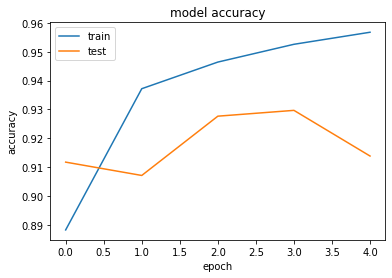

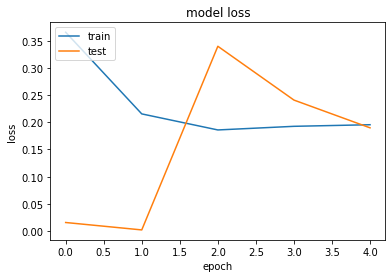

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
    
model.save("model.h5")
model.save_weights("model_weight.h5")
print("Saved model to disk")

In [15]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.95674855
validation_accuracy 0.9138373732566833


In [18]:
label = val_gen.classes
print(label)

[ 0  0  0 ... 17 17 17]


In [20]:
pred = model.predict(val_gen)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (val_gen.class_indices)  
labels2 = dict((v, k) for k, v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

[ 0  0  9 ... 17 17 17]
{'CR-CHEST': 0, 'CT-ABDOMEN': 1, 'CT-BREAST': 2, 'CT-CHEST': 3, 'CT-COLON': 4, 'CT-HEADNECK': 5, 'CT-KIDNEY': 6, 'CT-LUNG': 7, 'CT-PANCREAS': 8, 'DX-CHEST': 9, 'MG-BREAST': 10, 'MR-ABDOMEN': 11, 'MR-BRAIN': 12, 'MR-BREAST': 13, 'MR-HEADNECK': 14, 'MR-KIDNEY': 15, 'MR-PELVIS': 16, 'MR-PROSTATE': 17}
['CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'MR-KIDNEY', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'MR-BRAIN', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'MR-BRAIN', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'DX-CHEST', 'MR-PELVIS', 'DX-CHEST', 'CT-KIDNEY', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 

In [21]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices, label)

In [22]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=["Actual"], colnames=["Predicted"], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,All
Actual,,,,,,,,,,,,,,,,,,,
0,245,0,2,2,0,0,8,0,7,474,4,1,22,3,1,10,2,3,784
1,0,810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,810
2,0,0,847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,847
3,0,0,0,249,0,419,0,0,60,3,0,14,75,7,3,0,0,0,830
4,0,0,0,0,751,0,0,0,0,1,0,0,1,0,0,0,0,0,753
5,0,0,0,0,0,767,0,0,0,0,0,0,0,0,0,0,0,0,767
6,2,0,0,3,0,0,797,0,5,1,0,0,0,0,0,0,0,0,808
7,0,0,0,0,0,0,0,765,0,0,0,0,0,0,0,0,0,0,765
8,0,0,0,0,0,0,4,0,817,1,0,1,2,0,0,0,0,0,825
